In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
%matplotlib inline
DATA_FOLDER = '/home/azuredwp08/data/haystack/'

import pandas as pd
import pandas_profiling as pdp
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re

pd.set_option('display.max_columns', 150)

In [35]:
df = pd.read_csv(DATA_FOLDER + 'scenario5/haystack_email.csv')
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y %H:%M:%S')
df.head()

,activity,attachments,bcc,cc,content,date,from,id,pc,size,to,user
0,Send,NaN,NaN,Mary.Bo.Greer@dtaa.com,term 3000 sometimes were distinguish sexes 114...,2011-05-27 12:28:32,Mary.Bo.Greer@dtaa.com,{E1C6-M7EM35LA-4130GQLS},PC-0562,25511,Zena.Xantha.Roberson@dtaa.com,MBG1455
1,Send,NaN,NaN,LSK56@cox.net,"Two days after the storm, many of the roads ha...",2011-05-23 09:37:44,LSK56@cox.net,{H6T2-X3RW38DQ-3805TDHY},PC-9580,33284,Church-Erasmus@juno.com,LSK2577
2,Send,NaN,NaN,Kenneth.Jackson.Nichols@dtaa.com,day little time voyager 24 less extreme prospe...,2011-04-05 10:37:09,Kenneth.Jackson.Nichols@dtaa.com,{R6Z4-W6BX24NX-9621CGKZ},PC-7696,35087,Selma.Tatyana.Warner@dtaa.com,KJN0240
3,Receive,NaN,NaN,NaN,ahmose prince prince prince prince prince prin...,2010-12-28 13:24:23,Conan.Galvin.Sweet@dtaa.com,{C7A7-K0XN51WO-0071HDVZ},PC-0223,35313,Adrian.Brett.Lewis@dtaa.com,ABL1229
4,Receive,NaN,NaN,GPH35@gmail.com,initiating had key degree conference pre cours...,2010-04-08 11:33:12,BDC9@netzero.com,{H6U2-S0AI77HG-9172VFHH},PC-1576,29738,Medge_Hayden@hotmail.com;Adam.C.Haney@gmail.com,BDC0936


In [32]:
lg_df = pd.read_csv(DATA_FOLDER + 'scenario5/haystack_logon.csv')
lg_df['date'] = pd.to_datetime(lg_df['date'], format='%m/%d/%Y %H:%M:%S')
lg_df['just_date'] = lg_df['date'].dt.date
lg_df.head()

,id,date,user,pc,activity,just_date
0,{K1Q6-O5MP41BQ-6513CGUG},2010-10-05 08:32:00,ZJA2373,PC-9316,Logon,2010-10-05
1,{T1P1-S4UI62CV-3014WHGU},2010-05-28 06:20:10,COP0049,PC-0205,Logon,2010-05-28
2,{Y2M3-O5DA18YV-5153LXFM},2010-05-19 07:56:00,BNT0663,PC-6409,Logon,2010-05-19
3,{I1Z6-T2UG40LY-7701JZWL},2010-07-12 04:01:41,BBS0039,PC-8144,Logon,2010-07-12
4,{C5X4-E2GB11MB-0804IKCY},2011-03-10 02:50:42,ZEH0685,PC-8921,Logon,2011-03-10


### We may want to impute activity TODO

### Filter the duplicate user IDs users

In [13]:
# d = df[df['activity'] == 'Send']
# d[d['user'] == 'SSH1780']

In [36]:
df = df[~df['user'].isin(['BTR0403', 'CKR1700', 'SSH1780'])]

In [37]:
df.shape

(1541792, 12)

### Assumption :-)

In [38]:
df['activity'] = df['activity'].fillna('Send')  # assumption :-)   

### Remove those with no send activity

In [39]:
send_activity_users = df[df['activity'] == 'Send']['user'].unique()
no_send_act_users = [u for u in df['user'].unique() if u not in send_activity_users]

In [41]:
len(no_send_act_users)

8

In [42]:
df = df[~df['user'].isin(no_send_act_users)]

### Construct features

In [53]:
first_users = df['user'].unique()[:10]
first_groups = df[df['user'].isin(first_users)]
first_group = df[df['user'].isin(first_users[:1])]

In [48]:
def get_email_interactions(g):
    my_emails = g[g['activity'] == 'Send']['from'].unique()

    all_emails = []

    all_emails.extend(e for e in g['from'].values if e not in my_emails)

    g_sent = g[g['activity'] == 'Send']
    all_emails.extend(e for l in g_sent['to'].str.split(';').values for e in l if e not in my_emails)
    all_emails.extend(e for l in g_sent['cc'].dropna().str.split(';').values for e in l if e not in my_emails)
    all_emails.extend(e for l in g_sent['bcc'].dropna().str.split(';').values for e in l if e not in my_emails)

    all_emails = pd.Series(all_emails).value_counts()
    all_emails = all_emails/all_emails.sum()
    return my_emails, all_emails

sr = get_email_interactions(first_group)[1]
# sr

In [65]:
counter = 0

def _create_features(g):
    global counter
    counter += 1
    if counter % 100 == 0:
        print('Progress: {}'.format(counter))
     
    whole_g = g
    
    user = g.name
    print(user)
    
    # filter to send activity - TODO think about View activity as well?
    g = g[g['activity'] == 'Send']
    
    # is it sent from personal email?
    g['ft_pers_email'] = g['from'].apply(lambda x: x.endswith('@dtaa.com')).astype(int)
    
    ###############
    # DATE stuff
    ###############
    
    # minute of day
    g['ft_minute'] = g['date'].dt.hour*60 + g['date'].dt.minute  
    
    # number of days since first email - TODO - maybe since prev email?
    min_date = g['date'].min()
    g['ft_date'] = g['date'].apply(lambda d: (d - min_date).days)
    
    # is working day?
    g['ft_weekend'] = (g['date'].dt.dayofweek >= 5).astype(int)
    
    ###############
    # ATTACHMENTS/SIZE
    ###############
    
    # number of attachments
    g['ft_no_attach'] = g['attachments'].apply(lambda x: len(x.split(';')) if pd.notnull(x) else 0)
    
    # size of attachments
    g['ft_attach_size'] = g['attachments'].apply(lambda x: sum(
        int(m) for m in re.findall(r'\((\d+)\)', x)
    ) if pd.notnull(x) else 0)
    
    # the rest of the email size
    g['ft_text_size'] = g['size'] - g['ft_attach_size']
    
    ###############
    # LINKS
    ###############
    
    # avg. strength of links with people included in the email
    my_emails, email_interactions = get_email_interactions(whole_g)
    g['all_emails'] = g['to'].str.split(';') + g['cc'].fillna('').str.split(';') + g['bcc'].fillna('').str.split(';')
    def _get_score(emails):
        emails = [e for e in emails if e not in my_emails and e != '']
        
        if len(emails) == 0:
            return None
            
        return sum(email_interactions[e] for e in emails)/len(emails)
    g['ft_interact_score'] = g['all_emails'].apply(_get_score)
    g['ft_interact_score'] = g['ft_interact_score'].fillna(g['ft_interact_score'].mean())
    
    g['ft_number_recipients'] = g['all_emails'].apply(len)
    
    ###############
    # LOGON/LOGOFF
    ###############
    
    lg = lg_df[lg_df['user'] == user]
    lg = lg[lg['activity'] == 'Logoff']
#     lg_on = list(lg[lg['activity'] == 'Logon']['date'].sort_values())
#     lg_off = list(lg[lg['activity'] == 'Logoff']['date'].sort_values())
    
#     cur_on_i = 0
#     cur_off_i = 0
#     latest_lg_on = {}
#     earliest_lg_off = {}
#     for i, date in g['date'].sort_values().items():
#         while cur_on_i < len(lg_on) and lg_on[cur_on_i] <= date:
#             cur_on_i += 1
            
#         if cur_on_i > 0:
#             latest_lg_on[i] = lg_on[cur_on_i - 1]
        
#         while cur_off_i < len(lg_off) and lg_off[cur_off_i] < date:
#             cur_off_i += 1
            
#         if cur_off_i < len(lg_off):
#             earliest_lg_off[i] = lg_off[cur_off_i]
    
#     g['ft_latest_logon'] = pd.Series(latest_lg_on)
#     g['ft_earliest_logoff'] = pd.Series(earliest_lg_off)
  
    unique_pcs = lg.groupby(['just_date'])['pc'].nunique()
    unique_pcs.name = 'no_unique_pcs'
    g['just_date'] = g['date'].dt.date
    g['ft_no_unique_logon_pcs'] = g.join(unique_pcs, on='just_date')['no_unique_pcs'].fillna(1)

    ###############
    # CONTENT
    ###############
    
    all_content = ' '.join(g['content'])

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(g['content'])
    feature_names = np.array(vectorizer.get_feature_names())

    mean_tfidfs = []
    top_tfidfs = []
    no_diff_words = []
    avg_word_length = []
    for i in range(X.shape[0]):
        x = X[i]
        
        words = feature_names[x.toarray()[0] != 0]
        
        x = x[x != 0]
        
        mean_tfidfs.append(x.mean())
        top_tfidfs.append(np.quantile(x, 0.9))
        no_diff_words.append(x.shape[1])
        avg_word_length.append(np.array([len(w) for w in words]).mean())
        
    g['ft_mean_tfidf'] = mean_tfidfs
    g['ft_top_tfidf'] = top_tfidfs
    g['ft_no_diff_words'] = no_diff_words
    g['ft_vocal_variety'] = g['ft_no_diff_words'] / g['content'].str.split(' ').apply(len)
    g['ft_word_lengths'] = avg_word_length
    
    
    ng_vectorizer = TfidfVectorizer(ngram_range=(2,2))
    ng_X = ng_vectorizer.fit_transform(g['content'])
    
    ng_mean_tfidfs = []
    for i in range(ng_X.shape[0]):
        x = ng_X[i]
        x = x[x != 0]
        
        ng_mean_tfidfs.append(x.mean())
        
    g['ft_ng_mean_tfidf'] = ng_mean_tfidfs   
    
#     return g
    return g[[c for c in g.columns if c.startswith('ft_')]]

ftdf = df.groupby('user').apply(_create_features)

AAA1182
AAA1182
AAB1302
AAB1762
AAB3987
AAC0131
AAC0599
AAC0904
AAC1033
AAC1489
AAC1881
AAE0190
AAF0721
AAF0791
AAF2163
AAF3921
AAF3936
AAG1136
AAH0118
AAH0393
AAH0792
AAH3397
AAJ0723
AAL0706
AAL1327
AAM0469
AAM0559
AAM0972
AAM0982
AAM1951
AAN0700
AAN0823
AAO1119
AAO1919
AAP3230
AAR1793
AAS0442
AAS1285
AAS3663
AAV0450
AAW0353
AAW0914
AAW0952
AAW0969
AAZ2121
ABB0019
ABB2220
ABC0253
ABC1802
ABC1881
ABD3506
ABG0761
ABH0663
ABH1829
ABJ1155
ABL1229
ABM0845
ABM0890
ABM1021
ABM1851
ABM3748
ABN0239
ABP1681
ABR0482
ABR3486
ABV1812
ABW0686
ABW1277
ACA1126
ACA2637
ACA3690
ACB0220
ACB1087
ACB1485
ACC0042
ACC0950
ACC1855
ACC3205
ACD1174
ACD3420
ACE1431
ACF1356
ACG0007
ACG0152
ACG0234
ACG3477
ACH0937
ACH1011
ACH1831
ACH1840
ACH3250
ACJ1797
ACK1629
ACK1688
ACL0667
ACM2517
ACM2693
ACM2954
ACO0902
Progress: 100
ACP1494
ACR1045
ACR1286
ACR1367
ACS0589
ACS1548
ACS1868
ACT1903
ACT2336
ACV0812
ACW0078
ACW1602
ACW2684
ACW3220
ADA3688
ADB0799
ADC0391
ADC0889
ADC1014
ADC2744
ADC2989
ADD0846
ADD3481
ADF0397
AD

CAS2206
CAS3809
CAV0378
CAV0656
CBB0365
CBB1247
CBB1521
CBB2215
CBB2256
CBC0151
CBC0644
CBC1504
CBC1607
CBC3165
CBD1128
CBD1574
CBD3381
CBE2119
CBG0183
CBG0252
CBG0398
CBG0490
CBH1635
CBH3888
CBJ2532
CBK0185
CBK1205
CBK1908
CBM1272
CBM3332
CBM3605
CBM3757
CBN1983
CBO2061
CBP0507
CBP0768
CBP3955
CBR0796
CBR1084
CBR3713
CBS1856
CBS2799
CBS3228
CBW0961
CCA0046
CCB0076
CCB0964
CCB1161
CCB1836
CCB2748
CCB2960
CCB3358
CCB3860
CCC0393
CCC0515
CCC0569
CCC1691
CCC1703
CCC1900
CCD2103
CCG1347
CCH0182
CCH0685
CCH3183
CCH3930
CCK1540
CCL2414
CCM0136
CCM0467
CCM0612
CCM0716
CCM0855
CCM0947
CCM1270
CCM1401
CCM2101
CCM3460
CCP0774
CCP1460
CCP1491
CCR0152
CCR0338
CCR0863
CCR1396
CCR3246
CCS1172
CCT0142
CCV2519
CCV2865
CCW0031
CCW0097
CCW0524
Progress: 1100
CDA3761
CDB0711
CDB1594
CDD0405
CDD1124
CDD1586
CDD3833
CDG0551
CDG0770
CDG1272
CDG3902
CDH2031
CDJ3768
CDK3224
CDL0189
CDM1350
CDO0684
CDT2457
CDW2044
CEA1489
CEB0210
CEB1879
CEC1977
CEF1786
CEG1442
CEG1467
CEG1535
CEH1567
CEH2740
CEL0561
CEM1385
C

EGM1222
EGM1784
EGM2816
EGS1760
EHA0020
EHB0420
EHH0518
EHJ1339
EHK3412
EHL3331
EHM0340
EHM0441
EHM1969
EHN1746
EHP1804
EHR0096
EHR0834
EHS0205
EHV1087
EHW3925
EIB2663
EIC3121
EIM0156
EIP0997
EIP2711
EIR1946
EIS0041
EIW0714
EJB0241
EJB1013
EJC0104
EJC1225
EJG0858
EJG1445
EJJ0969
EJM0239
EJM1742
EJO0236
EJS3799
EJV0094
EJW0884
EJW1544
EKC2514
EKC3988
EKK3773
EKR0073
EKS1182
EKV3294
EKW2642
ELB0847
ELB3508
ELC1173
ELH0960
ELM1123
ELT0769
EMB0531
EMB0902
EMB1249
EMG1116
EMG3827
EMH2311
EMM0393
EMM0641
EMM2612
EMP3735
EMR0269
EMR1777
EMS0317
EMS0497
EMS2489
EMW0105
EMW0772
EMW2775
EMY1894
ENB1617
ENC0234
ENL0100
ENL1500
ENM1861
ENO0550
ENT1015
EOG0433
EOH1676
EOM3730
EOP3736
EOS1583
Progress: 2100
EPB0893
EPB2730
EPJ0445
EPP0057
EPT1398
EPW0434
EQH3532
EQW0396
ERB0104
ERB0921
ERB2969
ERB3344
ERH0449
ERI3138
ERM1590
ERR0525
ERV1880
ERW2323
ESA0642
ESD2034
ESH0135
ESH0283
ESH1028
ESJ0670
ESJ1200
ESM1828
ESN1173
ESP1198
ESR0693
ESW0928
ETC0235
ETC1855
ETD2727
ETE2728
ETF2956
ETH2186
ETL2436
E

ILH1650
ILH2000
ILJ0526
ILJ0929
ILJ1816
ILM1441
ILR0304
ILR1613
IMB0481
IMC0133
IMG0320
IMH0065
IMJ2320
IMK3365
IML0430
IMP0530
IMR0323
IMR3991
INB2668
INC0091
INC3857
ING2861
ING3393
INK1859
INM2363
INN1401
INR2905
INW1064
IOE0455
IOK2955
IOW2134
IPB0918
IPE2853
IPF0550
IPH0025
IQB1745
IQG0798
IQT0352
IQT3444
IQT3465
IRB0232
IRC1877
IRC2324
IRD1815
IRF2036
IRL3863
IRM0766
IRM0931
IRM2652
IRM2801
IRM3286
IRN1736
IRP1353
IRP1440
IRT0491
IRT2104
IRW1567
ISA2975
ISB1435
ISC2940
ISD1866
ISF3622
ISJ3822
ISK0116
ISR1604
ISS0304
ISS0508
ITC0015
ITC3192
ITD2081
ITD2516
ITM0068
ITP0153
ITS2511
ITV0200
IUH2250
IUM0292
IUY0279
IVB0821
IVS1411
Progress: 3100
IWL1032
IWM0816
IWS1389
IYB0918
IYF1060
IYH1611
IYI2185
IYR1331
IYS0556
JAA3738
JAB1917
JAC0457
JAC0721
JAC1275
JAC1524
JAC2952
JAC3425
JAD0609
JAD1379
JAD2071
JAD2095
JAG0106
JAG0861
JAH0337
JAH1070
JAH1802
JAH1941
JAH3408
JAJ0849
JAJ3208
JAM0382
JAM0752
JAM1887
JAR0794
JAR1211
JAR1708
JAR2800
JAS0428
JAS2566
JAS3289
JAS3480
JAT1218
JAT2921
J

LFR2971
LFS0071
LFS2302
LFV1268
LGB0236
LGC3084
LGO0047
LGS1468
LHA0303
LHB0606
LHB0967
LHB0977
LHB1412
LHC3406
LHD1233
LHD1750
LHD2959
LHG3457
LHL0130
LHL0309
LHM2040
LHM2675
LHN0151
LHP0320
LIB1125
LIC3132
LIG1756
LIH3678
LIJ1581
LIL1199
LIM0674
LIM2361
LIP3951
LIT0145
LIT1216
LJA2345
LJA2679
LJB0826
LJB1028
LJB1898
LJB2916
LJC1146
LJF1138
LJF1359
LJF2305
LJG0527
LJG1073
LJG2019
LJH1027
LJH1991
LJJ0905
LJK2935
LJL1891
LJM0215
LJM0375
LJM1807
LJP0965
LJP1584
LJR2063
LJR2569
LJS1922
LJT0817
LJV1620
LJW1505
LKB0734
LKB2745
LKC0405
LKC1796
LKD3896
LKJ1627
LKL1895
LKL3957
LKM0230
Progress: 4100
LKM1523
LKM2843
LKP1714
LKS1148
LKS1464
LKS2974
LKW0360
LLB0437
LLB1145
LLC2869
LLF1234
LLH0331
LLH1332
LLH2883
LLJ1130
LLL1469
LLM3025
LLP1436
LLR3772
LLT1337
LLV0602
LLW0179
LMA3295
LMC1678
LMF0980
LMG0065
LMK0920
LMM0167
LMP0801
LMP1543
LMP3363
LMR2564
LMR3907
LMS2198
LMT2858
LMT3309
LMW0475
LMW0837
LNC0729
LNC2844
LNC3210
LND1399
LNH0866
LNM2404
LNP3933
LNR0656
LNS0317
LNS0989
LOC0260
LOD1691
L

OMJ0680
OMJ3096
OMM0944
OMS0101
OMW1036
ONB0951
ONB1833
ONC1546
ONC2193
ONF0618
ONG1642
ONK0569
ONL0276
ONV1487
ONW0083
OOA2151
OPR1141
OPW1646
OQE0920
OQH0183
ORA1643
ORB0455
ORB0473
ORC0673
ORG0339
ORG0476
ORG0971
ORG1542
ORK1574
ORL3995
ORM0669
ORR0813
OSG3540
OSH0655
OSM1577
OSM3770
OSP3346
OSS0848
OSV3849
OTB0008
OTC3009
OTE0760
OTG0169
OTG1724
OTP3759
OVB1807
OVC1476
OVR3330
OWC0518
OWG2392
OWM3073
OWS0279
OWW2268
OXB3384
OXF0959
OYA3725
OYG0359
OYM0026
OZR0594
PAA0121
PAB0200
PAB3175
PAC3817
PAD0773
PAG0429
PAG1150
Progress: 5100
PAG3032
PAH0819
PAH1636
PAH3774
PAM0867
PAP0867
PAP1570
PAR3461
PAS3463
PAW1857
PBD1549
PBG1778
PBM3409
PBP0002
PBR0851
PBS0120
PBT2439
PCA0713
PCB0567
PCB3623
PCJ2393
PCK0271
PCM3766
PCS1641
PCS3456
PCT3691
PCW1522
PDB1680
PDB1766
PDF1317
PDG0186
PDH0716
PDH1180
PDM1326
PDM1431
PDM3248
PDS2808
PDT2177
PDW0259
PEM0277
PEM2884
PEM3892
PES0085
PES2571
PET1555
PEV0323
PFH2820
PFM1795
PGC0066
PGH0184
PGM2874
PGO0433
PGR0293
PGY1112
PHG1778
PHP0436
PHR2929
P

TAC0300
TAC3111
TAG1610
TAG1936
TAH0300
TAJ0023
TAK0125
TAK0501
TAK0546
TAL1665
TAM0029
TAM0267
TAP2284
TAR2007
TAS2750
TAV3675
TAW0161
TAW0689
TBA0283
TBA0471
TBC1006
TBE1972
TBF1107
TBG0491
TBH1514
TBL2627
TBM1476
TBM1904
TBP0548
TBR1368
TBR2601
TBS3865
TBT0461
TBT3515
TBT3588
TBW0692
TCA1183
TCB2455
TCC0311
TCC0771
TCC1298
TCC2442
TCC3217
TCD0009
TCD0797
TCF0559
TCF3986
TCH0264
TCH1093
TCJ0706
TCL0855
TCN3946
TCO1371
TCP1820
TCR0082
TCR0913
TCS0045
TCS2169
TCS2913
TCW0477
Progress: 6100
TCW1808
TDB1920
TDB2585
TDC0736
TDC0800
TDC1086
TDC2670
TDD3503
TDE0620
TDF0785
TDG0962
TDH1351
TDJ0998
TDK0753
TDR1930
TDR2945
TDS0984
TEB0251
TED3117
TEM0093
TEM0977
TEM1120
TES1064
TES1536
TES2231
TET0621
TFC3794
TFH3354
TFS1081
TFW1388
TFW1681
TGR1403
THB1069
THD0448
THF2265
THR0873
THS1590
THW2281
TIH0573
TIN3291
TIR0025
TIW0299
TJB0302
TJB1012
TJC1735
TJC3527
TJD0996
TJG0170
TJG0582
TJG0930
TJH1362
TJH1419
TJM1900
TJM2126
TJO0663
TJP0616
TJP2213
TJR0529
TJT0553
TJW2362
TJW2555
TKC0745
TKC1391
T

In [67]:
ftdf.to_csv('ftdf_full.csv')

In [61]:
# g = first_group

# user = g.iloc[0]['user']

# lg = lg_df[lg_df['user'] == user]
# lg = lg[lg['activity'] == 'Logoff']

# unique_pcs = lg.groupby(['just_date'])['pc'].nunique()
# unique_pcs.name = 'no_unique_pcs'
# # print(unique_pcs)
# g['just_date'] = g['date'].dt.date
# g['ft_no_unique_logon_pcs'] = g.join(unique_pcs, on='just_date')['no_unique_pcs'].fillna(1)
# g

In [263]:
pd.isnull(df['activity']).sum()

138118

In [272]:
df[pd.isnull(df['activity'])]['user']

5          FDE0117
8          ATE0869
25         AIS0405
43         KCF0045
47         RLG0856
66         MKL0941
74         AIH0675
95         SRH0155
126        RDM0150
128        BTS0011
136        MDM0976
142        BSS0369
157        MOH0273
159        JOL0024
166        AMR0318
167        MDM0625
173        ASL0378
177        IMB0481
180        YCE0983
183        MIC0726
196        CCA0046
203        JLM0364
224        KBB0189
229        IDO0176
231        WKD0013
248        LBH0942
249        RDT0424
250        UFK0208
256        CAN0842
259        SBK0161
            ...   
1542464    TLH0648
1542472    ATE0869
1542484    RTO0313
1542502    DHM0937
1542509    KBP0008
1542513    VIA0063
1542515    VTT0385
1542520    KJA0152
1542529    IBB0359
1542536    JJB0127
1542539    DTP0379
1542543    BEH0615
1542576    JLM0364
1542589    BSS0369
1542600    JTM0223
1542605    TDS0984
1542630    SER0165
1542668    CNE0352
1542678    BJW0619
1542682    OKC0107
1542683    SMB0804
1542687    L

In [271]:
sum(df[df['user'] == x]['activity'].sum() for x in df[pd.isnull(df['activity'])]['user'])

KeyboardInterrupt: 

In [255]:
df['activity'].count()/len(df)

0.9104172287831303

In [250]:
df['user'].nunique()

6838

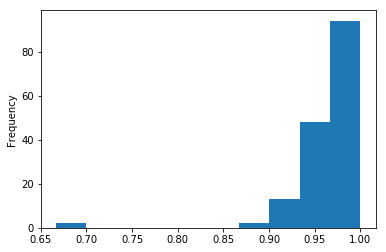

In [211]:
d['ft_vocal_variety'].plot.hist()

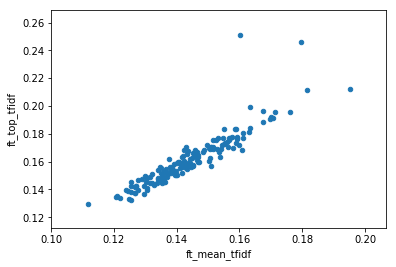

In [217]:
d.plot.scatter('ft_mean_tfidf', 'ft_top_tfidf')

In [12]:
d = lg_df[lg_df['user'] == 'MBG1455'].sort_values(by='date')

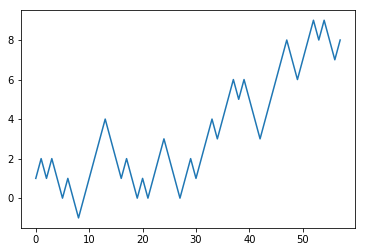

In [23]:
d['activity_num'] = d['activity'].replace({'Logon': 1, 'Logoff': -1})
d[['activity_num']].cumsum().reset_index()['activity_num'].plot()

In [31]:
lg_df

,id,date,user,pc,activity,day,just_date
0,{K1Q6-O5MP41BQ-6513CGUG},2010-10-05 08:32:00,ZJA2373,PC-9316,Logon,5,2010-10-05
1,{T1P1-S4UI62CV-3014WHGU},2010-05-28 06:20:10,COP0049,PC-0205,Logon,28,2010-05-28
2,{Y2M3-O5DA18YV-5153LXFM},2010-05-19 07:56:00,BNT0663,PC-6409,Logon,19,2010-05-19
3,{I1Z6-T2UG40LY-7701JZWL},2010-07-12 04:01:41,BBS0039,PC-8144,Logon,12,2010-07-12
4,{C5X4-E2GB11MB-0804IKCY},2011-03-10 02:50:42,ZEH0685,PC-8921,Logon,10,2011-03-10
5,{Z3M7-N1EI85ZP-0534XZBN},2011-01-29 07:42:00,DSH0923,PC-8009,Logon,29,2011-01-29
6,{O9R6-J7GW07YU-1547QXLU},2011-05-21 08:52:00,NJB0011,PC-2311,Logon,21,2011-05-21
7,{M9S4-Q3DJ37GG-2620DGZM},2011-01-18 17:10:00,IBM1752,PC-3459,Logoff,18,2011-01-18
8,{W9K9-B5CO79EE-1158NKTL},2011-05-27 08:32:00,RLM3469,PC-8826,Logon,27,2011-05-27
9,{A6R5-S4YF56MM-4955TWRP},2010-05-27 06:53:00,JBO2839,PC-2626,Logon,27,2010-05-27


In [95]:
next(g['date'].items())


(0, Timestamp('2011-05-27 12:28:32'))

In [110]:
lg_df['date'][0]

Timestamp('2011-05-27 12:28:32')

In [11]:
user = 'LAH0463'

lg = lg_df[lg_df['user'] == user]
lg_on = lg[lg['activity'] == 'Logon'].sort_values(by='date')
lg_off = lg[lg['activity'] == 'Logoff'].sort_values(by='date')

pd.set_option('display.max_rows', 1000)
lg.sort_values(by='date')

,id,date,user,pc,activity
181966,{R3D8-Y7UZ05QQ-8244WPIV},2010-01-04 01:29:28,LAH0463,PC-2353,Logon
580536,{H2W8-V0YP88EQ-8293EHZC},2010-01-04 01:35:23,LAH0463,PC-2353,Logoff
479295,{S4K4-U5IP59DW-4933SYKH},2010-01-04 08:15:00,LAH0463,PC-2749,Logon
152334,{S0B1-C0KB91QW-3137IWZQ},2010-01-04 16:43:00,LAH0463,PC-2749,Logoff
585772,{R9X7-D5UX40BI-3887PCSK},2010-01-05 00:38:36,LAH0463,PC-5960,Logon
615987,{H5J4-J7ZP78HU-1713JVLU},2010-01-05 00:47:35,LAH0463,PC-5960,Logoff
507058,{W9B2-K7GP34BZ-6590ZIPO},2010-01-05 01:41:44,LAH0463,PC-6829,Logon
476384,{L0T8-E6CC21BU-1703JXRY},2010-01-05 01:51:02,LAH0463,PC-6829,Logoff
665242,{Q2E6-V3QD39MR-0527BDWX},2010-01-05 01:53:06,LAH0463,PC-9809,Logon
53653,{E3O3-P3CH22XK-6767SYHT},2010-01-05 02:11:04,LAH0463,PC-9809,Logoff


In [56]:
g = re.search(r'\((\d+)\)', 'fsdfsd(13431432).docx')
g.group(1)

'13431432'